# Clustering<span class="tocSkip"></span>

The goal of this program is to visualize and cluster the data.

## Importing files and liberaries
* Importing the libaries that are necessary:

In [1]:
import numpy as np
import pandas as pd
import random as rnd

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

* Importing the necessary files:
 * Read files
 * Convert read files to data
 * Save data in dataframes

In [2]:
read_data = open('Data\Voorbeeld_clusterdata.txt')
data = read_data.read()
data = data.splitlines()
read_data.close()

read_results = open('Data\Voorbeeld_clusterresult.txt')
results = read_results.read()
results = results.splitlines()
read_results.close()

def convert(array):
    line_data = []

    for line in array:
        segment = []
        for elem in line.split():
            segment.append(float(elem))
        line_data.append(segment)
    
    return line_data

cordinates = ['z','y','x','w','v','u','t','s']
df_data = pd.DataFrame(convert(data),columns=['ID','z','y','x','w','v','u','t','s']).set_index('ID')
df_results = pd.DataFrame(convert(results), columns=['ID','label']).set_index('ID')
df_clusterd = df_data.copy().drop(columns=cordinates)

df_data.head()

,z,y,x,w,v,u,t,s
ID,,,,,,,,
846160.0,0.388,0.329,0.690,0.900,0.626,0.621,0.399,0.370
820434.0,-0.296,-0.503,-0.454,-0.868,-0.721,-0.918,-0.486,-0.582
849103.0,-0.246,-0.935,-0.277,-0.175,-0.278,-0.075,-0.236,-0.417
846353.0,0.769,0.929,0.977,1.095,1.058,0.864,0.689,0.492
848613.0,-0.365,-0.760,-0.305,-0.293,-0.364,-0.155,-0.472,-0.606


## Visualising the data:

To visualise the 8-dimensional data we need to convert it to at least a 4-dimensional space. This can be done by calculate 4 centroids by definng the mean of 2 cordinates. This gives the following result:

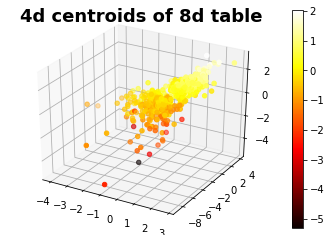

In [3]:
x = df_data[cordinates[:2]].mean(axis=1)
y = df_data[cordinates[2:4]].mean(axis=1)
z = df_data[cordinates[4:6]].mean(axis=1)
c = df_data[cordinates[6:]].mean(axis=1)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
img = ax.scatter(x, y, z, c=c, cmap=plt.hot())
fig.colorbar(img)
plt.title('4d centroids of 8d table',weight='bold',size=18);

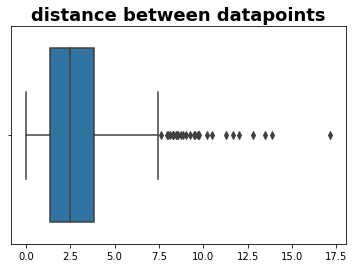

In [23]:
diff = df_data.diff()
diff = np.power(diff, 2)
distance = np.sqrt(diff.sum(axis=1))
sns.boxplot(distance)
plt.title('distance between datapoints', weight='bold', size=18);

## K-means (KMCA):

In [5]:
class KMCA:
    def __init__(self, k=6, tol=0.001, max_iter=300):
        self.k = k
        self.tol = tol
        self.max_iter = max_iter

    def fit(self,data):

        self.centroids = {}

        for i in range(self.k):
            self.centroids[i] = data[i]

        for i in range(self.max_iter):
            self.classifications = {}

            for i in range(self.k):
                self.classifications[i] = []

            for featureset in data:
                distances = [np.linalg.norm(featureset-self.centroids[centroid]) for centroid in self.centroids]
                classification = distances.index(min(distances))
                self.classifications[classification].append(featureset)

            prev_centroids = dict(self.centroids)

            for classification in self.classifications:
                self.centroids[classification] = np.average(self.classifications[classification],axis=0)

            optimized = True

            for c in self.centroids:
                original_centroid = prev_centroids[c]
                current_centroid = self.centroids[c]
                if np.sum((current_centroid-original_centroid)/original_centroid*100.0) > self.tol:
                    optimized = False

            if optimized:
                break

    def predict(self,data):
        distances = [np.linalg.norm(data-self.centroids[centroid]) for centroid in self.centroids]
        classification = distances.index(min(distances))
        return classification

### get cluster:

In [6]:
clf = KMCA()
clf.fit(df_data[cordinates].values)

cluster = []

for i in df_data[cordinates].values:
    cluster.append(clf.predict(i))

df_clusterd['KMCA'] = cluster

## K-Nearest Neighbors (KNN)


In [7]:
class knn:
    def __init__(self,k=5):
        self.k = k
        
    def set_K(self, k):
        self.k = k
     
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        
    def predict(self, X_test):
        def _get_label(x):
            distances = [np.linalg.norm(x - x_train) for x_train in self.X_train]
            k_indices = np.argsort(distances)[:self.k]
            k_labels = [self.y_train[i] for i in k_indices]

            def mode(array):
                most = max(list(map(array.count, array)))
                return list(set(filter(lambda x: array.count(x) == most, array)))

            return mode(k_labels)[0]
    
        knn_labels = [_get_label(x) for x in X_test]
        
        return np.array(knn_labels)

### get cluster:

In [8]:
cls = knn()

X_train = df_data[cordinates].values[:(len(df_data)//2)]
y_train = df_results['label'].values[:(len(df_data)//2)]
X_test = df_data[cordinates].values

cls.fit(X_train,y_train)
df_clusterd['KNN'] = cls.predict(X_test)

## Density-Based Spatial Clustering of Applications with Noise (DBSCAN):

In [34]:
class DBSCAN():
    """A density based clustering method that expands clusters from 
    samples that have more neighbors within a radius specified by eps
    than the value min_samples.
    Parameters:
    -----------
    eps: float
        The radius within which samples are considered neighbors
    min_samples: int
        The number of neighbors required for the sample to be a core point. 
    """
    def __init__(self, eps=distance.quantile(q=0.10), min_samples=5):
        self.eps = eps
        self.min_samples = min_samples
        
    def _get_neighbors(self, sample_i):
        """ Return a list of indexes of neighboring samples
        A sample_2 is considered a neighbor of sample_1 if the distance between
        them is smaller than epsilon """
        
        def euclidean_distance(x1,x2):
            return np.sqrt(np.sum((x1-x2)**2))
        
        neighbors = []
        idxs = np.arange(len(self.X))
        for i, _sample in enumerate(self.X[idxs != sample_i]):
            distance = euclidean_distance(self.X[sample_i], _sample)
            if distance < self.eps:
                neighbors.append(i)
        return np.array(neighbors)

    def _expand_cluster(self, sample_i, neighbors):
        """ Recursive method which expands the cluster until we have reached the border
        of the dense area (density determined by eps and min_samples) """
        cluster = [sample_i]
        # Iterate through neighbors
        for neighbor_i in neighbors:
            if not neighbor_i in self.visited_samples:
                self.visited_samples.append(neighbor_i)
                # Fetch the sample's distant neighbors (neighbors of neighbor)
                self.neighbors[neighbor_i] = self._get_neighbors(neighbor_i)
                # Make sure the neighbor's neighbors are more than min_samples
                # (If this is true the neighbor is a core point)
                if len(self.neighbors[neighbor_i]) >= self.min_samples:
                    # Expand the cluster from the neighbor
                    expanded_cluster = self._expand_cluster(
                        neighbor_i, self.neighbors[neighbor_i])
                    # Add expanded cluster to this cluster
                    cluster = cluster + expanded_cluster
                else:
                    # If the neighbor is not a core point we only add the neighbor point
                    cluster.append(neighbor_i)
        return cluster

    def _get_cluster_labels(self):
        """ Return the samples labels as the index of the cluster in which they are
        contained """
        # Set default value to number of clusters
        # Will make sure all outliers have same cluster label
        labels = np.full(shape=self.X.shape[0], fill_value=len(self.clusters))
        for cluster_i, cluster in enumerate(self.clusters):
            for sample_i in cluster:
                labels[sample_i] = cluster_i
        return labels

    # DBSCAN
    def predict(self, X):
        self.X = X
        self.clusters = []
        self.visited_samples = []
        self.neighbors = {}
        n_samples = np.shape(self.X)[0]
        # Iterate through samples and expand clusters from them
        # if they have more neighbors than self.min_samples
        for sample_i in range(n_samples):
            if sample_i in self.visited_samples:
                continue
            self.neighbors[sample_i] = self._get_neighbors(sample_i)
            if len(self.neighbors[sample_i]) >= self.min_samples:
                # If core point => mark as visited
                self.visited_samples.append(sample_i)
                # Sample has more neighbors than self.min_samples => expand
                # cluster from sample
                new_cluster = self._expand_cluster(
                    sample_i, self.neighbors[sample_i])
                # Add cluster to list of clusters
                self.clusters.append(new_cluster)

        # Get the resulting cluster labels
        cluster_labels = self._get_cluster_labels()
        return cluster_labels

### get cluster:

In [35]:
clf = DBSCAN()
df_clusterd['DBSCAN'] = clf.predict(df_data[cordinates].values)

## Visualise evaluated data

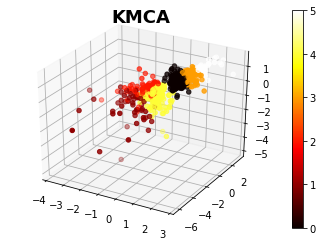

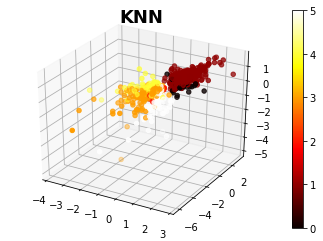

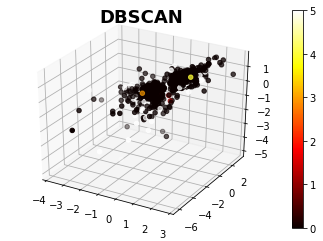

In [36]:
def plot(col):
    x = df_data[cordinates[:3]].mean(axis=1)
    y = df_data[cordinates[3:7]].mean(axis=1)
    z = df_data[cordinates[7:]].mean(axis=1)
       
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    img = ax.scatter(x, y, z, c=df_clusterd[col], cmap=plt.hot())
    fig.colorbar(img);
    plt.title(col,weight='bold',size=18)
    
for col in df_clusterd.columns:
    plot(col)